In [1]:
import itertools
import pandas as pd
import numpy as np

# Data at 150h exposure from user tables

# Cutoff energies (TeV)
cutoff = {
    "Fermi": (35.9, 32.9),
    "Eichmann": (12.2, 25.5),
    "Ajello": (140, 167),
    "Kornecki": (36.3, 28.9),
    "Peretti": (39.7, 107),
    "Inoue": (0.39, 0.06),
    "Stacked": (7.65, 22.1),
}

# Amplitude (1/(TeV s cm^2))
amplitude = {
    "Fermi": (6.3e-14, 0.59e-14),
    "Eichmann": (4.2e-14, 0.78e-14),
    "Ajello": (6.2e-14, 0.64e-14),
    "Kornecki": (1.6e-13, 0.07e-13),
    "Peretti": (2.3e-14, 0.79e-14),
    "Inoue": (2.8e-16, 6.9e-16),
    "Stacked": (2.3e-15, 4.4e-15),
}

# Index
index = {
    "Fermi": (2.29, 0.12),
    "Eichmann": (2.37, 0.26),
    "Ajello": (2.39, 0.15),
    "Kornecki": (2.19, 0.06),
    "Peretti": (2.05, 0.42),
    "Inoue": (1.93, 0.30),
    "Stacked": (1.88, 0.90),
}

models = list(cutoff.keys())

def zscore(val1, err1, val2, err2):
    return abs(val1 - val2) / np.sqrt(err1**2 + err2**2)

results = []
for m1, m2 in itertools.combinations(models, 2):
    z_cut = zscore(*cutoff[m1], *cutoff[m2])
    z_amp = zscore(*amplitude[m1], *amplitude[m2])
    z_ind = zscore(*index[m1], *index[m2])
    results.append((m1, m2, z_cut, z_amp, z_ind))

df = pd.DataFrame(results, columns=["Model 1", "Model 2", "Z-cutoff", "Z-amp", "Z-index"])
df

,Model 1,Model 2,Z-cutoff,Z-amp,Z-index
0,Fermi,Eichmann,0.569366,2.147221,0.279372
1,Fermi,Ajello,0.611598,0.114882,0.520579
2,Fermi,Kornecki,0.009134,10.595558,0.745356
3,Fermi,Peretti,0.033946,4.056787,0.549442
4,Fermi,Inoue,1.079330,10.558549,1.114172
5,Fermi,Stacked,0.712780,8.247252,0.451559
6,Eichmann,Ajello,0.756501,1.982239,0.066630
7,Eichmann,Kornecki,0.625297,11.259050,0.674579
8,Eichmann,Peretti,0.250008,1.711434,0.647821
9,Eichmann,Inoue,0.463136,5.327912,1.108344


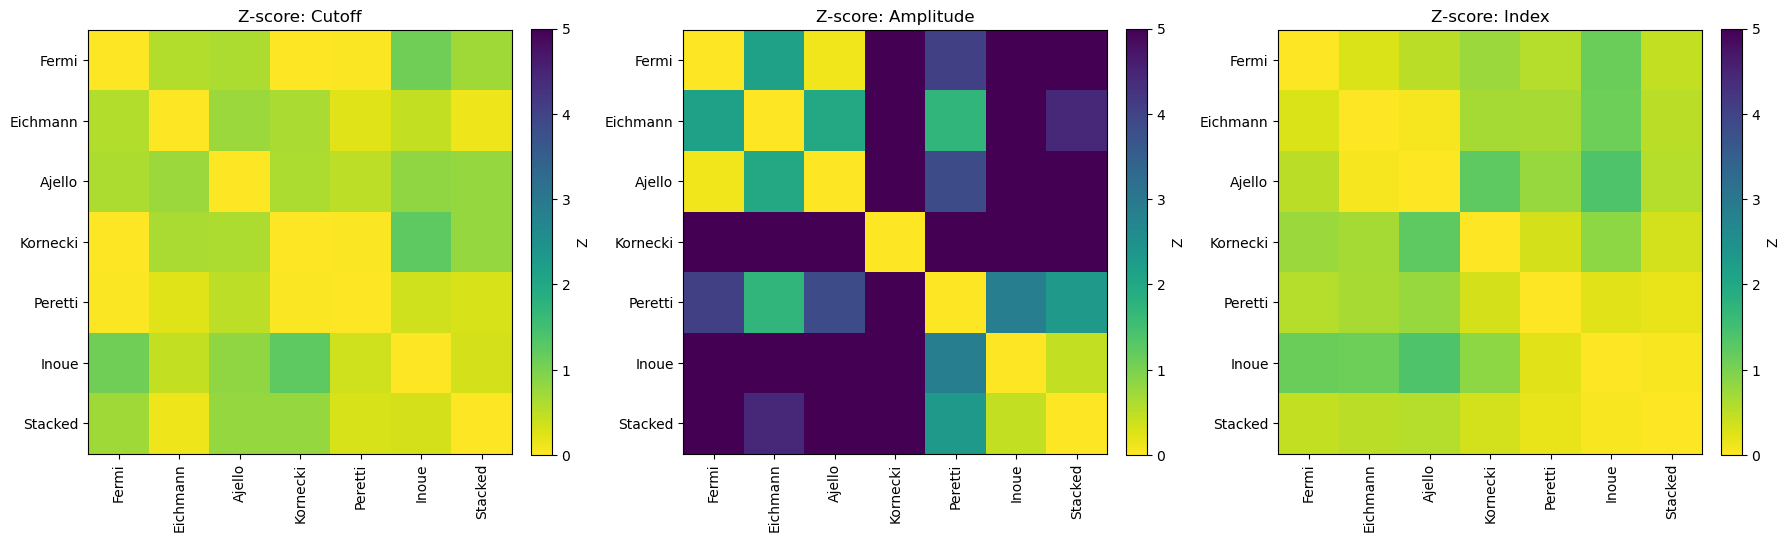

In [2]:
import matplotlib.pyplot as plt

# Create a pivot table for each parameter
def make_matrix(df, column):
    mat = pd.DataFrame(index=models, columns=models, dtype=float)
    for _, row in df.iterrows():
        m1, m2, val = row["Model 1"], row["Model 2"], row[column]
        mat.loc[m1, m2] = val
        mat.loc[m2, m1] = val
        mat.loc[m1, m1] = 0
        mat.loc[m2, m2] = 0
    return mat

mat_cutoff = make_matrix(df, "Z-cutoff")
mat_amp = make_matrix(df, "Z-amp")
mat_index = make_matrix(df, "Z-index")

# Plot heatmaps
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, mat, title in zip(axes, [mat_cutoff, mat_amp, mat_index],
                          ["Z-score: Cutoff", "Z-score: Amplitude", "Z-score: Index"]):
    im = ax.imshow(mat.values.astype(float), cmap="viridis_r", vmin=0, vmax=5)
    ax.set_xticks(range(len(models)))
    ax.set_yticks(range(len(models)))
    ax.set_xticklabels(models, rotation=90)
    ax.set_yticklabels(models)
    ax.set_title(title)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Z")

plt.tight_layout()
plt.show()

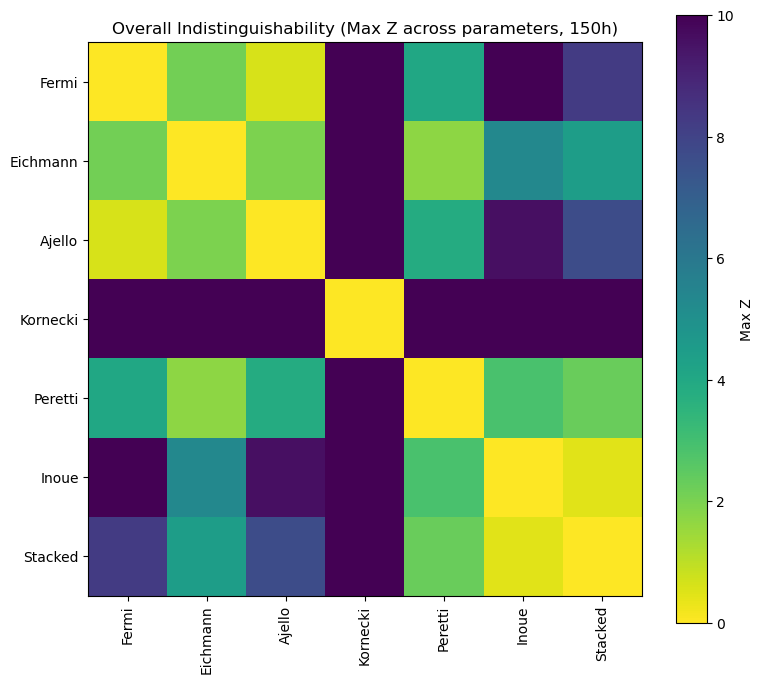

,Fermi,Eichmann,Ajello,Kornecki,Peretti,Inoue,Stacked
Fermi,0.000000,2.147221,0.611598,10.595558,4.056787,10.558549,8.247252
Eichmann,2.147221,0.000000,1.982239,11.259050,1.711434,5.327912,4.433057
Ajello,0.611598,1.982239,0.000000,10.332403,3.835901,9.588187,7.686766
Kornecki,10.595558,11.259050,10.332403,0.000000,12.979515,22.707095,19.073512
Peretti,4.056787,1.711434,3.835901,12.979515,0.000000,2.865042,2.289145
Inoue,10.558549,5.327912,9.588187,22.707095,2.865042,0.000000,0.453548
Stacked,8.247252,4.433057,7.686766,19.073512,2.289145,0.453548,0.000000


In [3]:
# Build a combined matrix: take the maximum Z across the three parameters for each pair
mat_combined = pd.DataFrame(index=models, columns=models, dtype=float)

for _, row in df.iterrows():
    m1, m2 = row["Model 1"], row["Model 2"]
    max_z = max(row["Z-cutoff"], row["Z-amp"], row["Z-index"])
    mat_combined.loc[m1, m2] = max_z
    mat_combined.loc[m2, m1] = max_z
    mat_combined.loc[m1, m1] = 0
    mat_combined.loc[m2, m2] = 0

# Plot heatmap of combined Z
plt.figure(figsize=(8, 7))
im = plt.imshow(mat_combined.values.astype(float), cmap="viridis_r", vmin=0, vmax=10)
plt.xticks(range(len(models)), models, rotation=90)
plt.yticks(range(len(models)), models)
plt.title("Overall Indistinguishability (Max Z across parameters, 150h)")
plt.colorbar(im, label="Max Z")
plt.tight_layout()
plt.show()

mat_combined